In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, silhouette_score, calinski_harabasz_score
from collections import Counter

In [ ]:
# 加载鸢尾花数据集
iris = datasets.load_iris()
X = iris.data 
y_true = iris.target  # 真实标签

# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [116]:
# K-means
import time
def kmeans(X, k, max_iters=500, tol=1e-6):
    # np.random.seed(int(time.time()))
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    for _ in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids , axis=2) # 
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    return labels, centroids

In [95]:
# DBSCAN
def dbscan(X, eps, min_samples):
    labels = np.full(X.shape[0], -1)
    cluster_id = 0

    for i in range(X.shape[0]):
        if labels[i] != -1:
            continue

        neighbors = np.where(np.linalg.norm(X-X[i], axis=1) < eps)[0]
        # print('index',i,'neighbors:',neighbors)

        if len(neighbors) < min_samples:
            continue
        
        labels[i] = cluster_id
        # print(f'Setting {i}th node(centroid node) to cluster {cluster_id}.')
        seeds = set(neighbors)
        # print('seeds',seeds)
        while seeds:
            point = seeds.pop()
            if labels[point] == -1:
                labels[point] = cluster_id

            elif labels[point] != -1:
                continue

            new_neighbors = np.where(np.linalg.norm(X-X[point], axis=1) < eps)[0]

            if len(new_neighbors) >= min_samples:
                seeds.update(new_neighbors)
                # print(f'Setting {point}th node(centroid node) to cluster {cluster_id}.')
        cluster_id += 1
    return labels

In [135]:
k_list = [2, 3, 4, 5, 6, 7, 8]
kmeans_labels_list = []
for k in k_list:
    kmeans_labels, _ = kmeans(X, k)
    kmeans_labels_list.append(kmeans_labels)

In [103]:
eps_list = [0.3, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8]
dbscan_labels_list = []
for eps in eps_list:
    dbscan_labels = dbscan(X, eps, min_samples=5)
    dbscan_labels_list.append(dbscan_labels)

In [98]:
def evaluate_clustering(X, labels, y_true):
    labels = np.array(labels)
    label_map = {}
    for cluster_label in np.unique(labels):
        if cluster_label == -1:
            continue # skip the noise
        true_labels = y_true[labels == cluster_label]
        most_common = Counter(true_labels).most_common(1)[0][0]
        label_map[cluster_label] = most_common

    mapped_labels = np.array([label_map.get(label, -1) for label in labels])

    accuracy = accuracy_score(y_true[mapped_labels != -1], mapped_labels[mapped_labels != -1])
    silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
    calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
    
    return accuracy, silhouette, calinski_harabasz

In [136]:
kmeans_acc_list = []
kmeans_sil_list = []
kmeans_ch_list = []

for i, kmeans_labels in zip(k_list,kmeans_labels_list):
    kmeans_acc, kmeans_sil, kmeans_ch = evaluate_clustering(X, kmeans_labels, y_true)
    kmeans_acc_list.append(kmeans_acc)
    kmeans_ch_list.append(kmeans_ch)
    kmeans_sil_list.append(kmeans_sil)
    print(f"K-means (k={i}): Accuracy={kmeans_acc:.3f}, Silhouette={kmeans_sil:.3f}, CH={kmeans_ch:.3f}")


K-means (k=2): Accuracy=0.667, Silhouette=0.582, CH=251.349
K-means (k=3): Accuracy=0.667, Silhouette=0.460, CH=156.567
K-means (k=4): Accuracy=0.840, Silhouette=0.397, CH=191.387
K-means (k=5): Accuracy=0.840, Silhouette=0.325, CH=190.522
K-means (k=6): Accuracy=0.947, Silhouette=0.397, CH=152.754
K-means (k=7): Accuracy=0.920, Silhouette=0.324, CH=161.325
K-means (k=8): Accuracy=0.860, Silhouette=0.291, CH=150.644


In [132]:
dbscan_acc_list = []
dbscan_sil_list = []
dbscan_ch_list = []

for i, dbscan_labels in zip(eps_list,dbscan_labels_list):
    dbscan_acc, dbscan_sil, dbscan_ch = evaluate_clustering(X, dbscan_labels, y_true)
    dbscan_acc_list.append(dbscan_acc)
    dbscan_ch_list.append(dbscan_ch)
    dbscan_sil_list.append(dbscan_sil)
    print(f"DBScan (eps={i}): Accuracy={dbscan_acc:.3f}, Silhouette={dbscan_sil:.3f}, CH={dbscan_ch:.3f}")

DBScan (eps=0.3): Accuracy=1.000, Silhouette=-0.194, CH=16.881
DBScan (eps=0.4): Accuracy=1.000, Silhouette=0.028, CH=23.481
DBScan (eps=0.45): Accuracy=0.979, Silhouette=0.181, CH=51.241
DBScan (eps=0.5): Accuracy=0.724, Silhouette=0.357, CH=84.510
DBScan (eps=0.6): Accuracy=0.710, Silhouette=0.403, CH=91.023
DBScan (eps=0.7): Accuracy=0.681, Silhouette=0.523, CH=116.142
DBScan (eps=0.8): Accuracy=0.678, Silhouette=0.522, CH=126.221


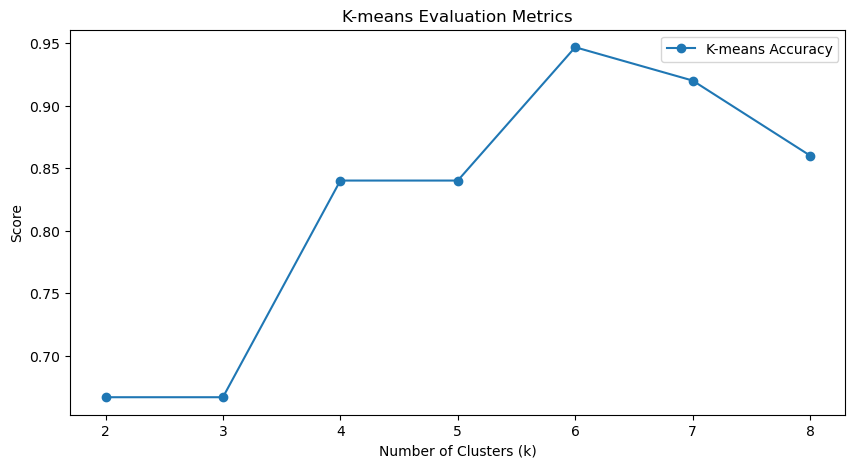

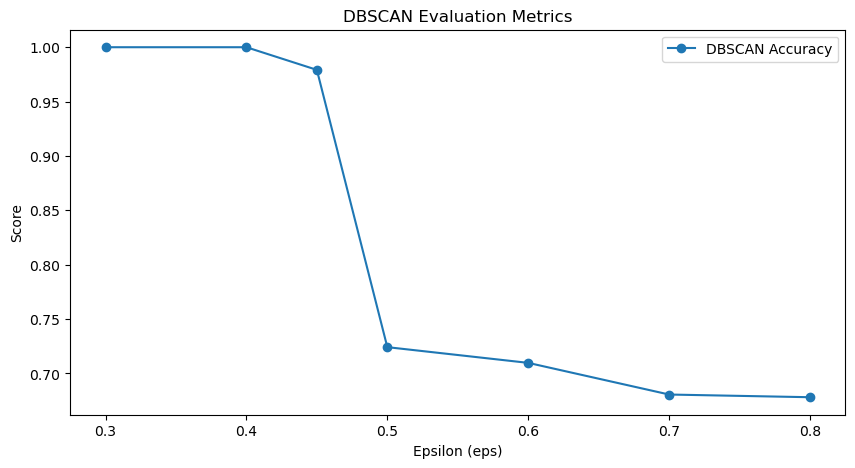

In [137]:
# 画出评估指标折线图

plt.figure(figsize=(10, 5))
plt.plot(k_list, kmeans_acc_list, marker='o', label='K-means Accuracy')
# plt.plot(k_list, kmeans_sil_list, marker='s', label='K-means Silhouette Score')
# plt.plot(k_list, kmeans_ch_list, marker='^', label='K-means Calinski-Harabasz Index')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.legend()
plt.title('K-means Evaluation Metrics')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(eps_list, dbscan_acc_list, marker='o', label='DBSCAN Accuracy')
# plt.plot(eps_list, dbscan_sil_list, marker='s', label='DBSCAN Silhouette Score')
# plt.plot(eps_list, dbscan_ch_list, marker='^', label='DBSCAN Calinski-Harabasz Index')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Score')
plt.legend()
plt.title('DBSCAN Evaluation Metrics')
plt.show()

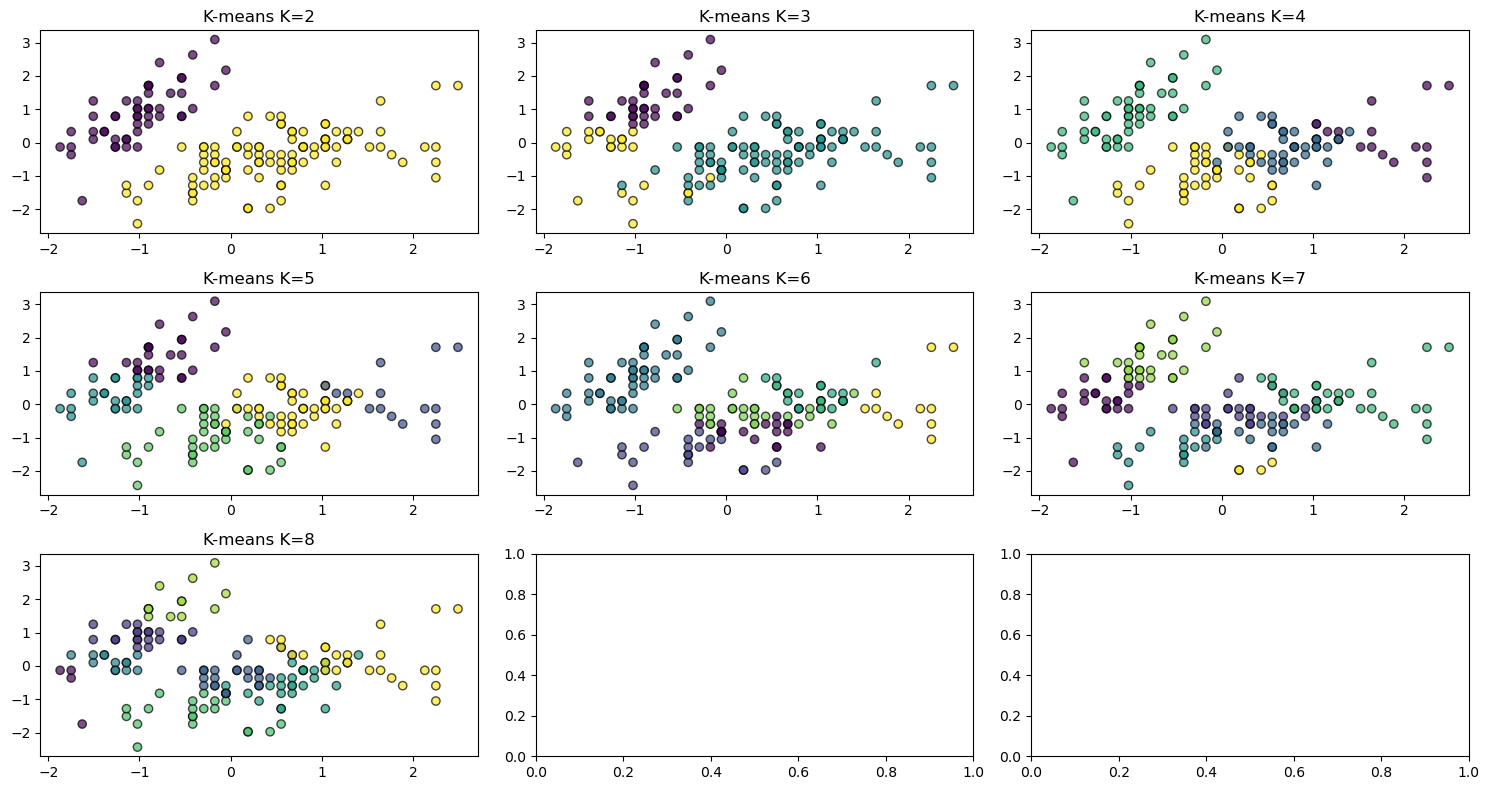

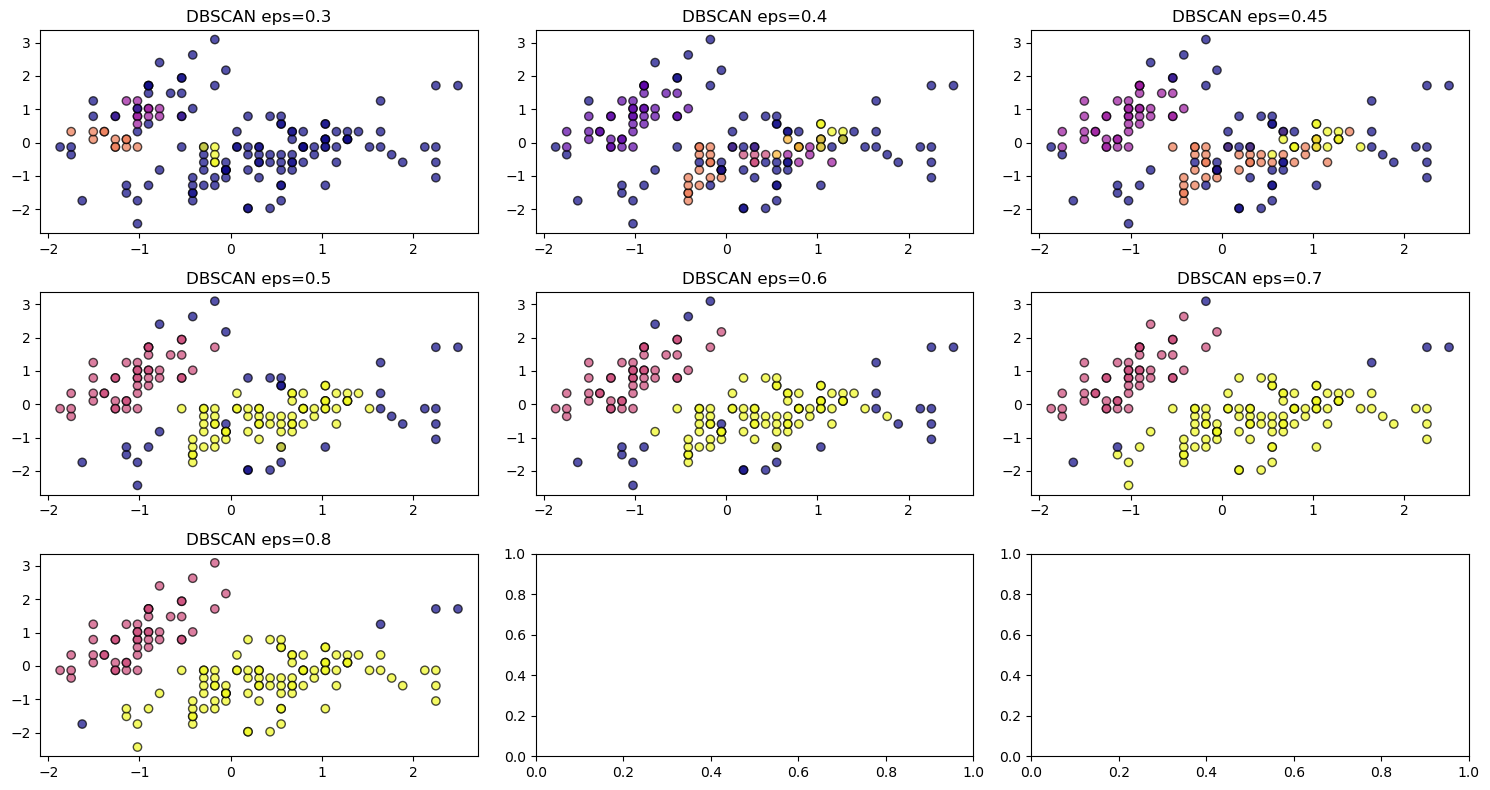

In [138]:
# 画出所有 K-means 和 DBSCAN 聚类结果
fig, axes = plt.subplots(3, len(k_list) // 2, figsize=(15, 8))
axes = axes.ravel()

for i, k in enumerate(k_list):
    labels = kmeans_labels_list[i]
    axes[i].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', edgecolor='k', alpha=0.7)
    axes[i].set_title(f'K-means K={k}')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, len(eps_list) // 2, figsize=(15, 8))
axes = axes.ravel()

for i, eps in enumerate(eps_list):
    labels = dbscan_labels_list[i]
    axes[i].scatter(X[:, 0], X[:, 1], c=labels, cmap='plasma', edgecolor='k', alpha=0.7)
    axes[i].set_title(f'DBSCAN eps={eps}')

plt.tight_layout()
plt.show()
